This is used in the paper **Flexible cable routing framework for wind farm collection system optimization**.

In [1]:
import math
import dill
from pyomo import environ as pyo
from importlib.resources import files

In [2]:
from interarray.interarraylib import G_from_S
from interarray.svg import svgplot
from interarray.mesh import make_planar_embedding
from interarray.baselines.hgs import hgs_multiroot
from interarray.importer import L_from_yaml
from interarray.pathfinding import PathFinder
import interarray.MILP.pyomo as omo

## Reference solutions

Cazzaro, D., & Pisinger, D. (2022). Balanced cable routing for offshore wind farms with obstacles. Networks, 80(4), 386–406. https://doi.org/10.1002/net.22100

In [3]:
G140_ref = dill.load(open('cazzaro_2022G_140_paper_routeset.dill', 'rb'))

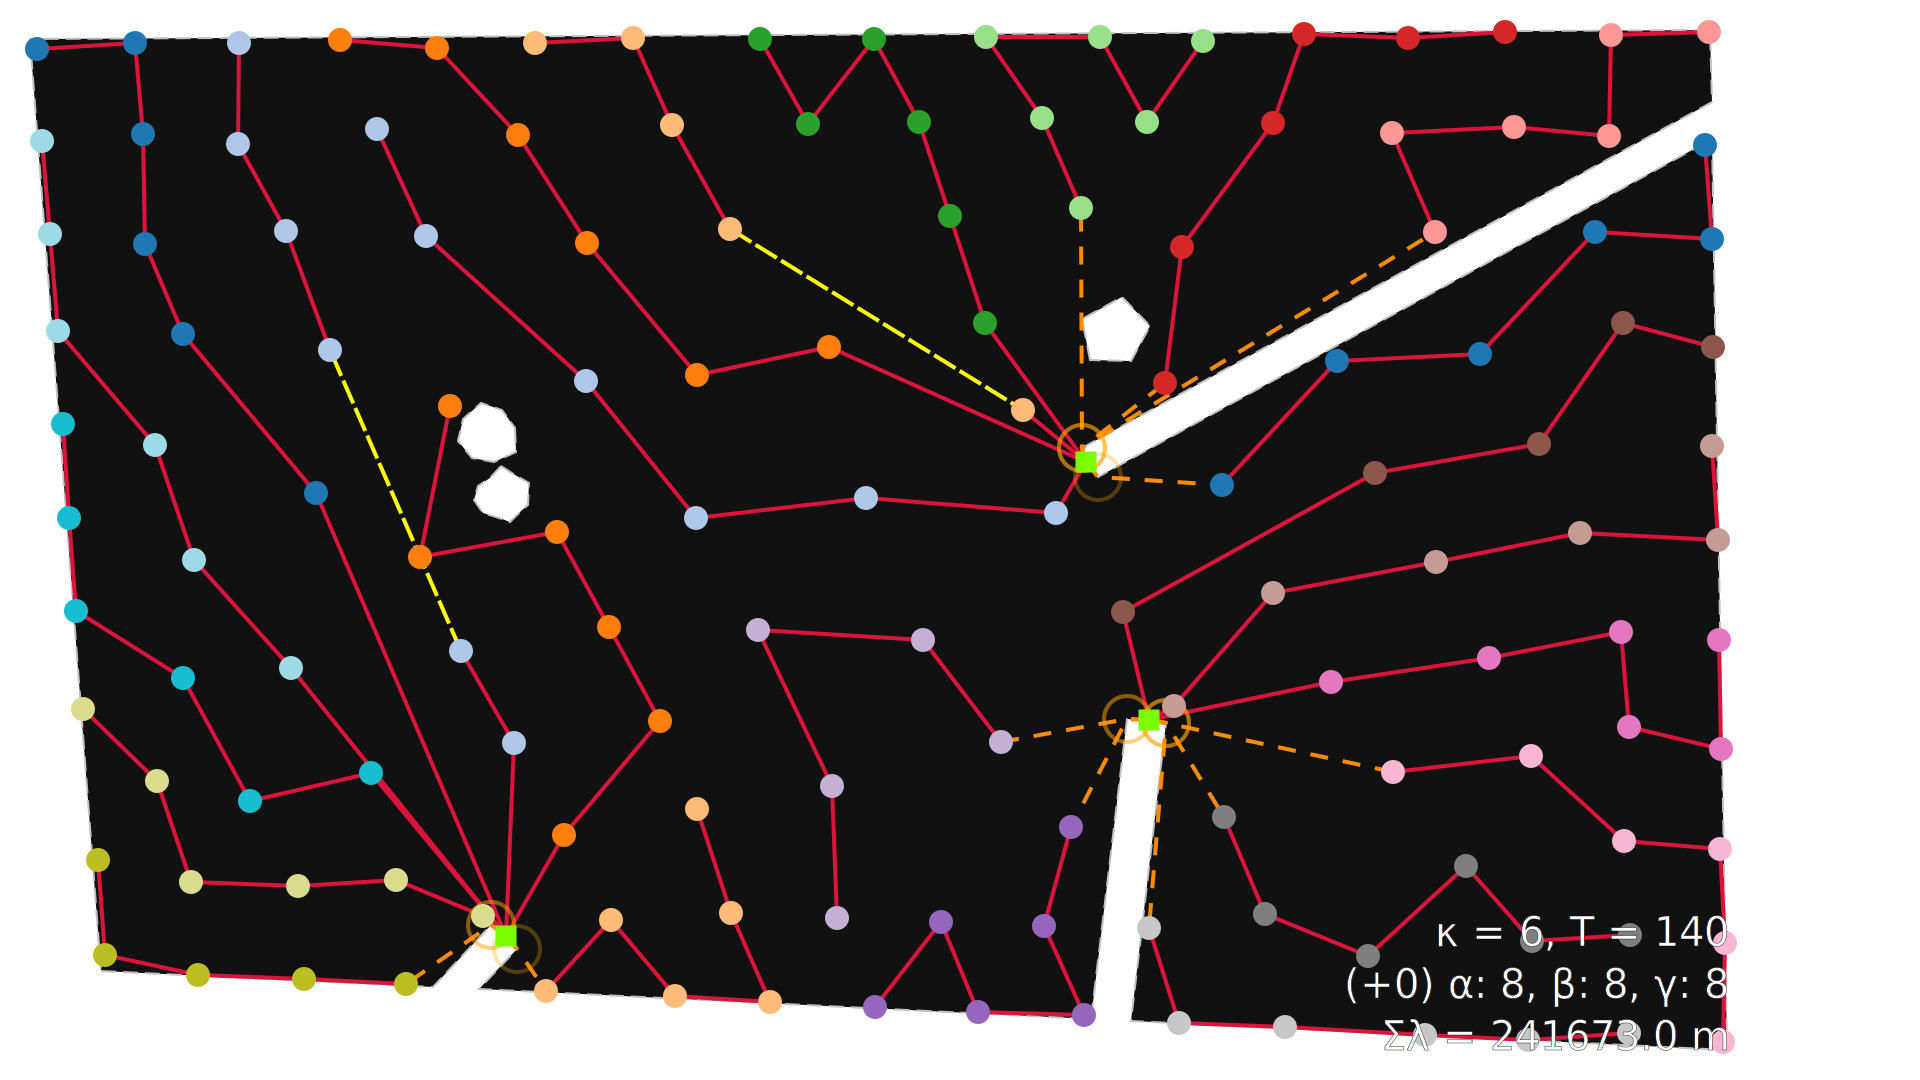

In [4]:
svgplot(G140_ref)

In [5]:
G210_ref = dill.load(open('cazzaro_2022G_210_paper_routeset.dill', 'rb'))

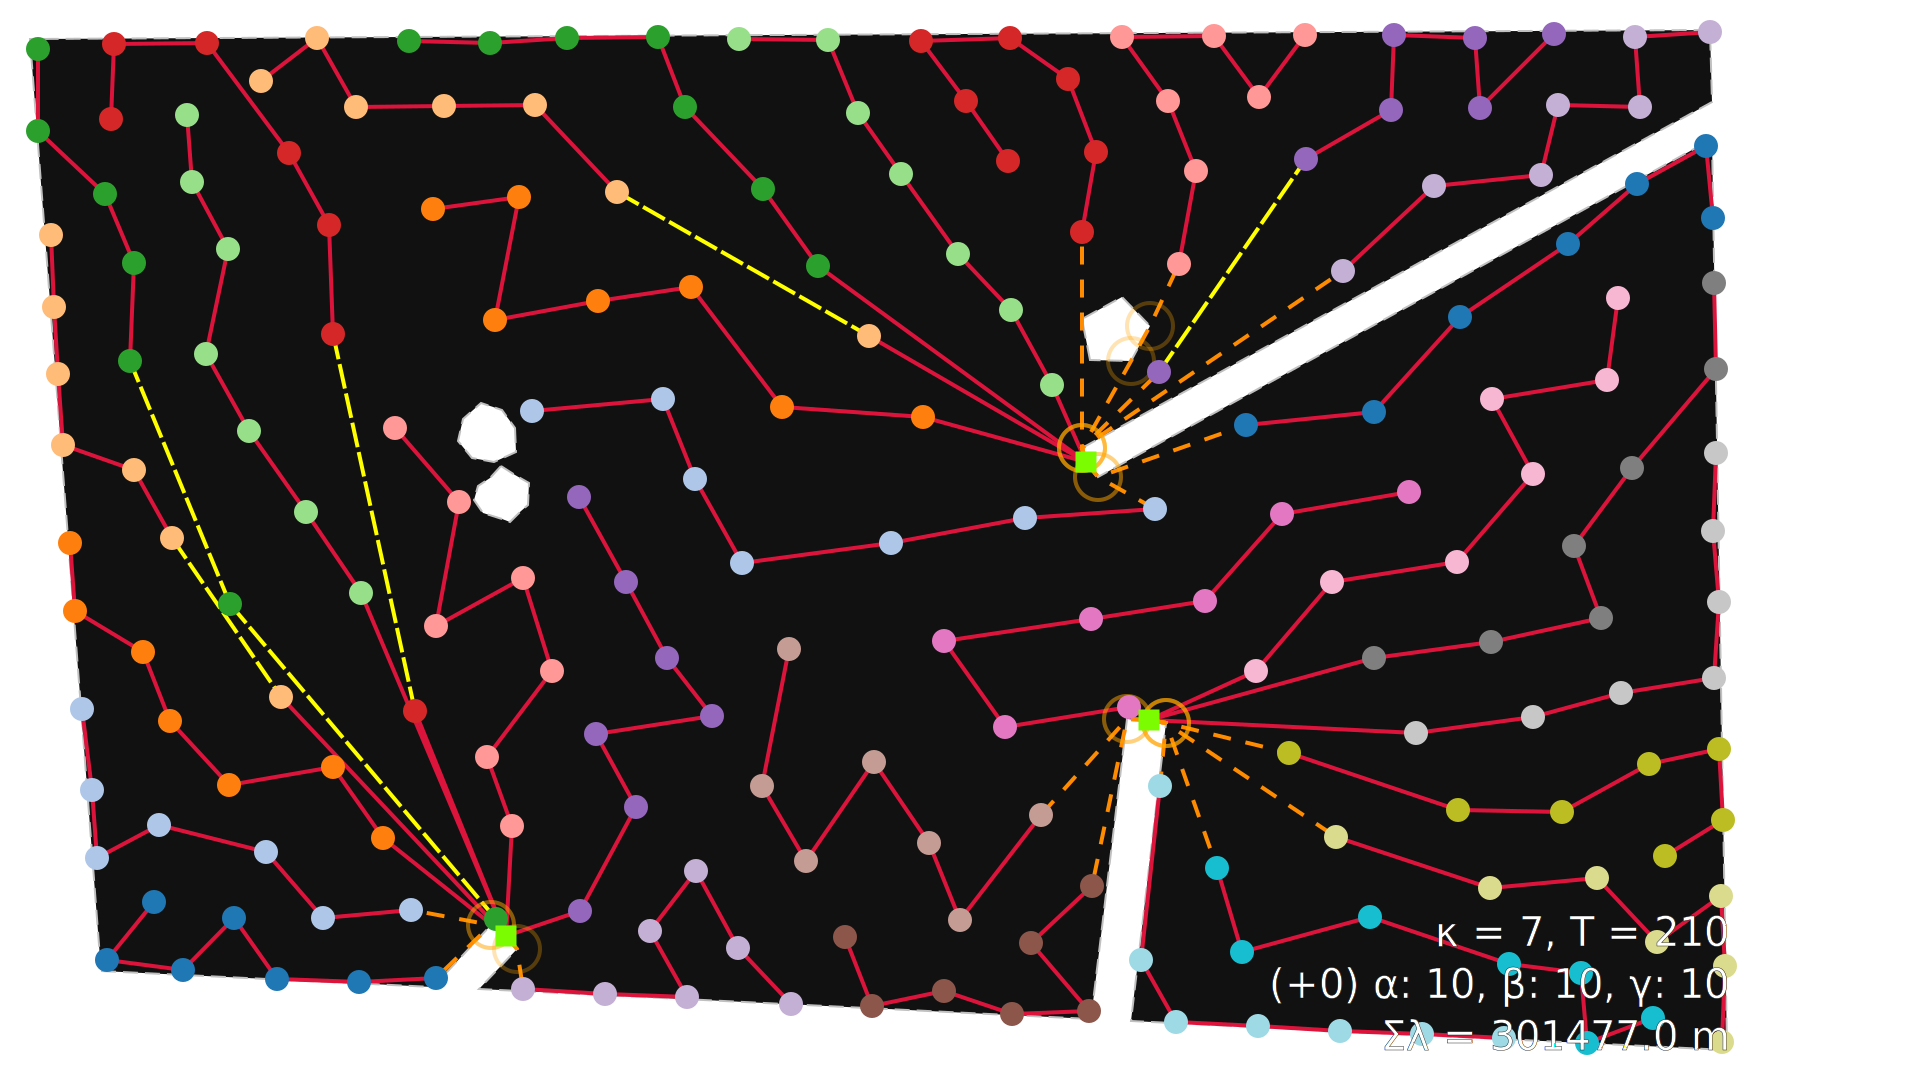

In [6]:
svgplot(G210_ref)

## Start here

## Instantiate solver

In [7]:
gurober = pyo.SolverFactory('gurobi', solver_io='python')

## G-140, κ = 6

In [8]:
L140 = L_from_yaml(files('interarray.data') / 'Cazzaro-2022G-140.yaml')

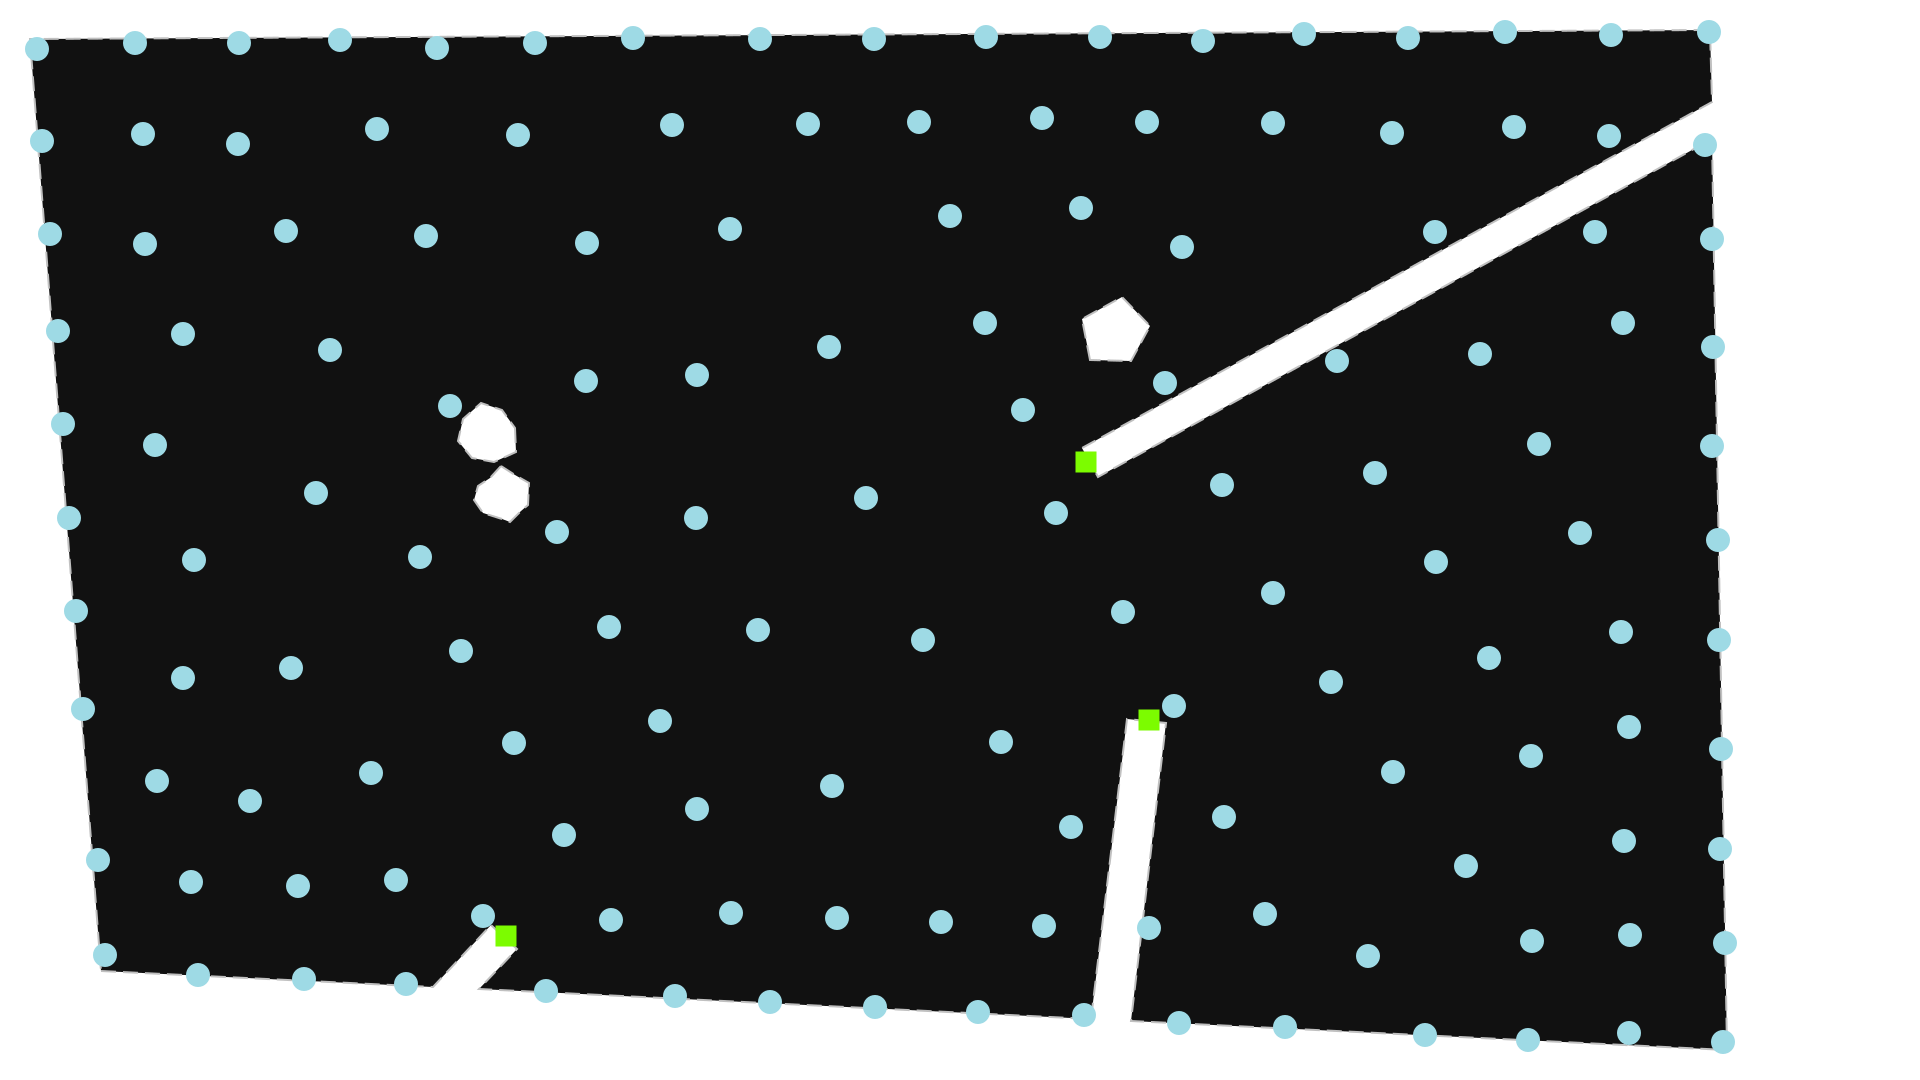

In [9]:
svgplot(L140)

In [10]:
P, A = make_planar_embedding(L140)

In [11]:
Sʹ = hgs_multiroot(A, capacity=6, time_limit=0.3, balanced=True)

In [12]:
Sʹ.graph['solution_time']

(0.2, 0.04, 0.19)

In [13]:
Gʹ = G_from_S(Sʹ, A)

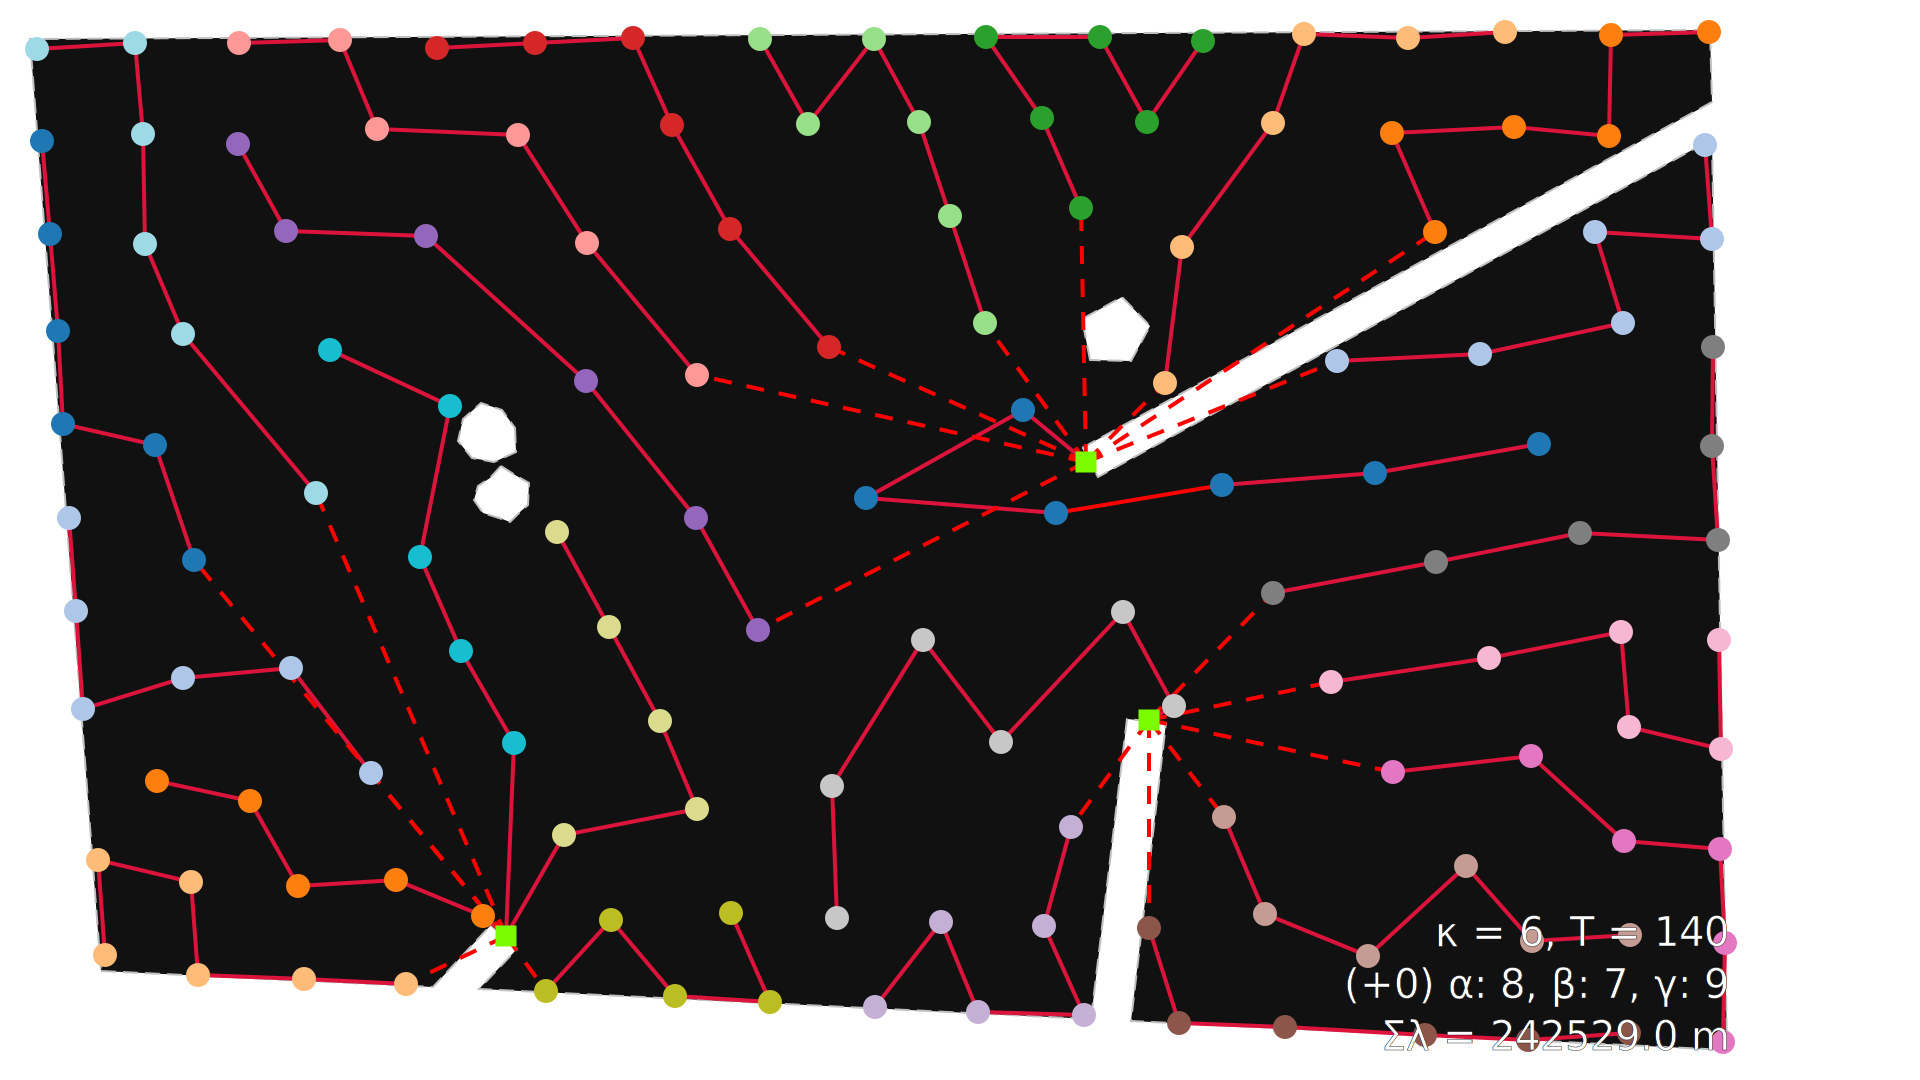

In [14]:
svgplot(Gʹ)

In [15]:
[[Sʹ[r][n]['load'] for n in Sʹ[r]] for r in range(-3, 0)]

[[6, 6, 6, 6, 6, 6, 6, 6, 6], [6, 6, 6, 6, 6, 6, 6], [5, 5, 5, 6, 6, 6, 5, 6]]

In [16]:
Hʹ = PathFinder(Gʹ, planar=P, A=A, branching=False).create_detours()

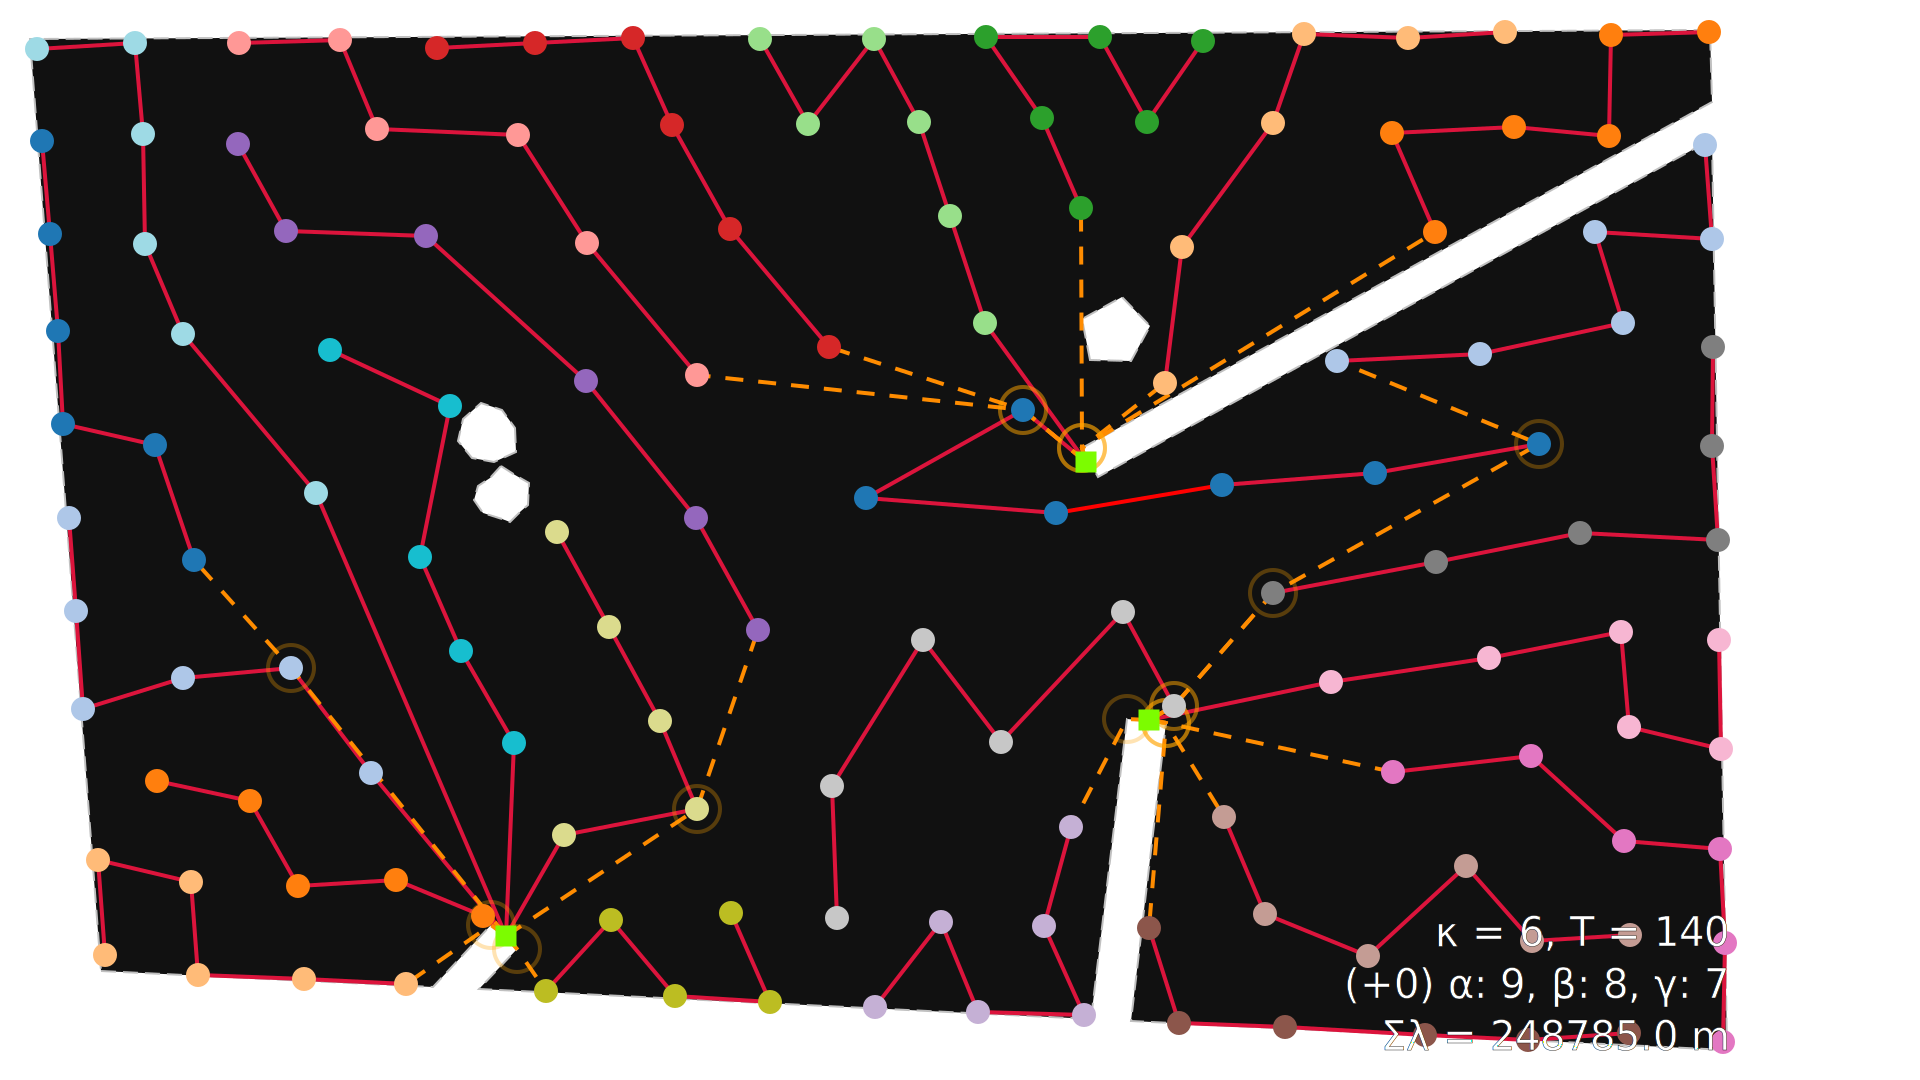

In [17]:
svgplot(Hʹ)

In [18]:
Hʹ.size(weight='length')/G140_ref.size(weight='length') - 1

0.02943087228611052

In [19]:
capacity = 6
# build model and pre-load solution from Sʹ
model = omo.make_min_length_model_balanced(
    A, capacity,
    num_gates=math.ceil(A.graph['T']/capacity),
    gateXings_constraint=False,
    branching=False
)
omo.warmup_model_balanced(model, Sʹ)

In [20]:
gurober.options.mipgap = 0.005  # 0.5 %
gurober.options.timelimit = 10  # [s]
gurober.options.mipfocus = 1  # focus on producing solutions
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, k={model.k.value}}}\n')
status = gurober.solve(model, warmstart=model.warmed_by, tee=True)

Solving "None": {R=3, T=140, k=6}

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 10
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  10
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 4338 rows, 3372 columns and 21102 nonzeros
Model fingerprint: 0x38561f08
Variable types: 0 continuous, 3372 integer (2106 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [4e+02, 2e+04]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 1e+02]

Loaded user MIP start with objective 242529

Presolve removed 685 rows and 560 columns
Presolve time: 

In [21]:
H140 = omo.gurobi_investigate_pool_balanced(P, A, model, gurober, status)

Solution pool has 10 solutions.
Incumbent has (detoured) length: 236639.148
Pool investigation over - next best undetoured length: 236688.479


In [22]:
[[H140[r][n]['load'] for n in H140[r]] for r in range(-3, 0)]

[[6, 6, 6, 6, 6, 6, 6, 5, 6, 6], [6, 6, 6, 5, 5, 6], [5, 6, 6, 6, 6, 6, 6, 6]]

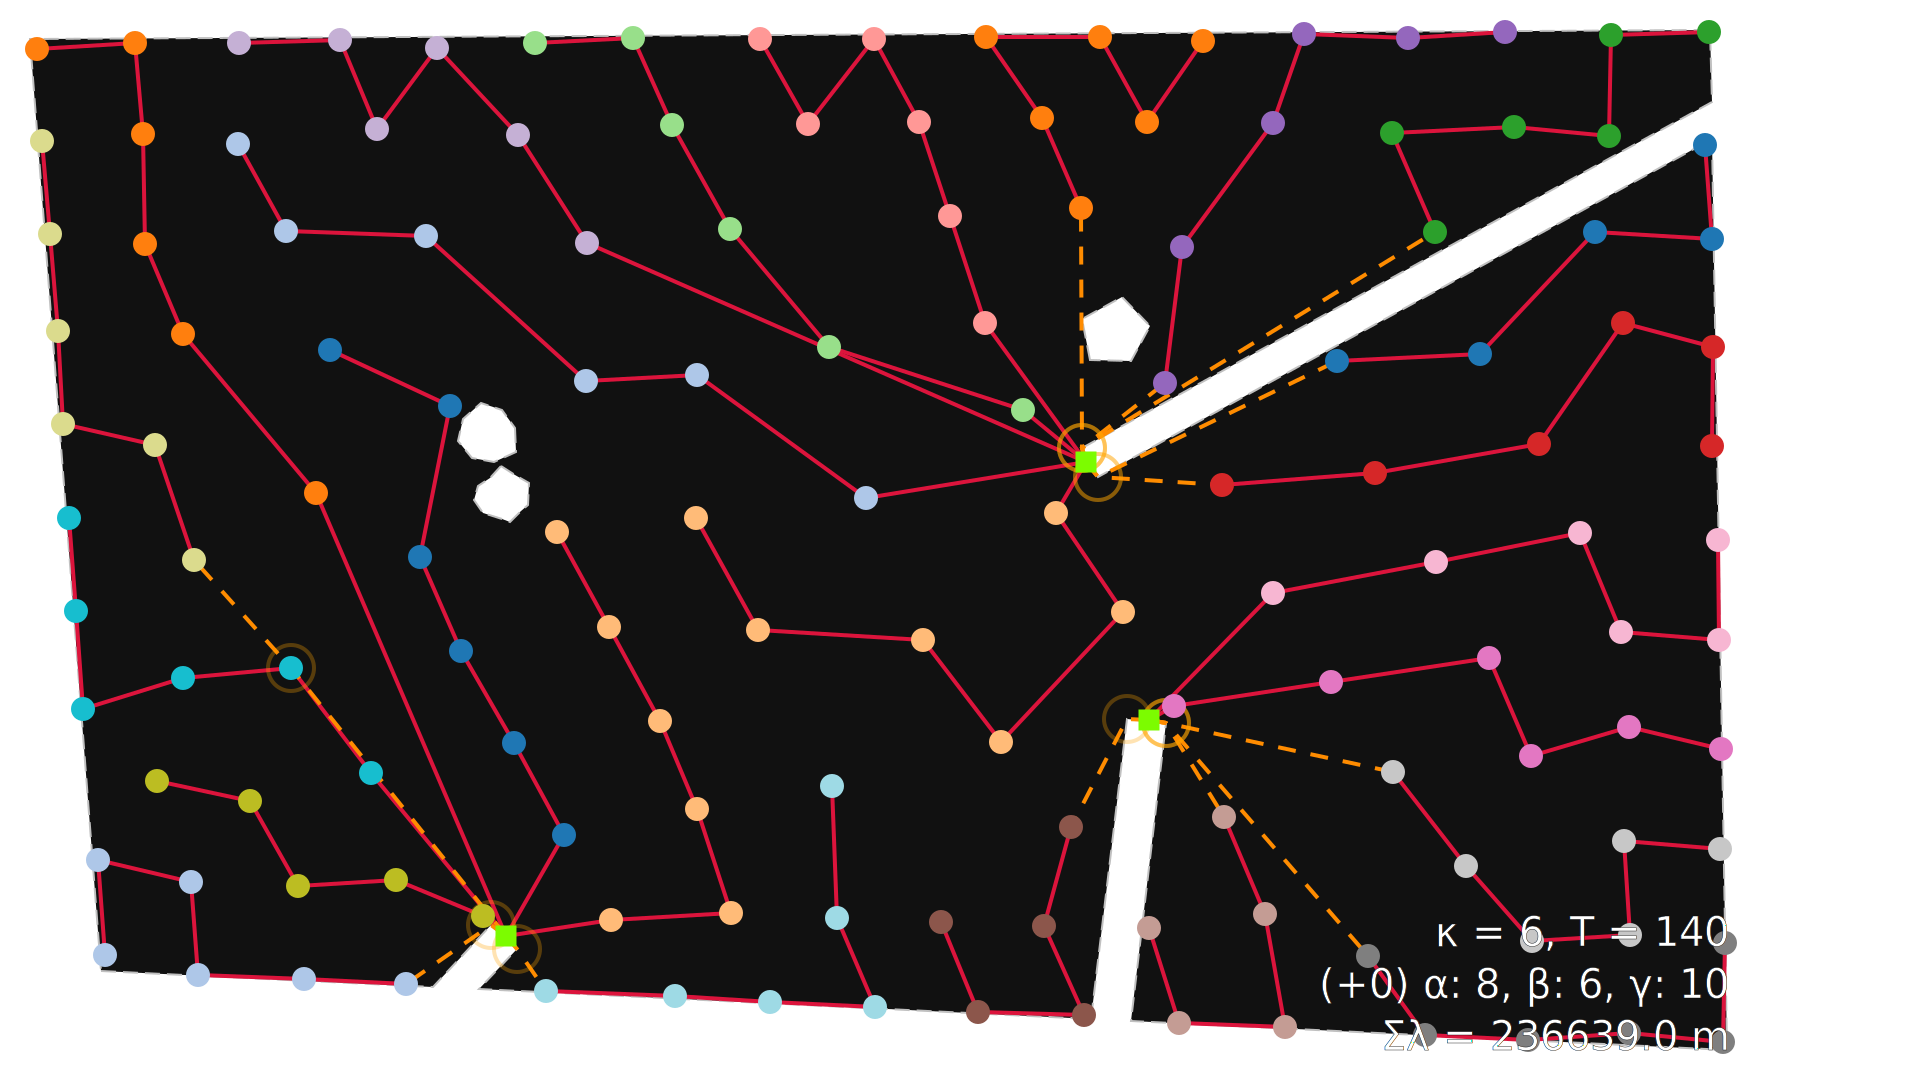

In [23]:
svgplot(H140)

In [24]:
with open('cazzaro_2022G_140_κ_6_radial_balanced_ours_236639.dill', 'wb') as outfile:
    dill.dump(H140, outfile)

In [25]:
1 - H140.size(weight='length')/G140_ref.size(weight='length')

0.020828468287038326

## G-210, κ = 7

In [26]:
L210 = L_from_yaml(files('interarray.data') / 'Cazzaro-2022G-210.yaml')

In [27]:
P, A = make_planar_embedding(L210)

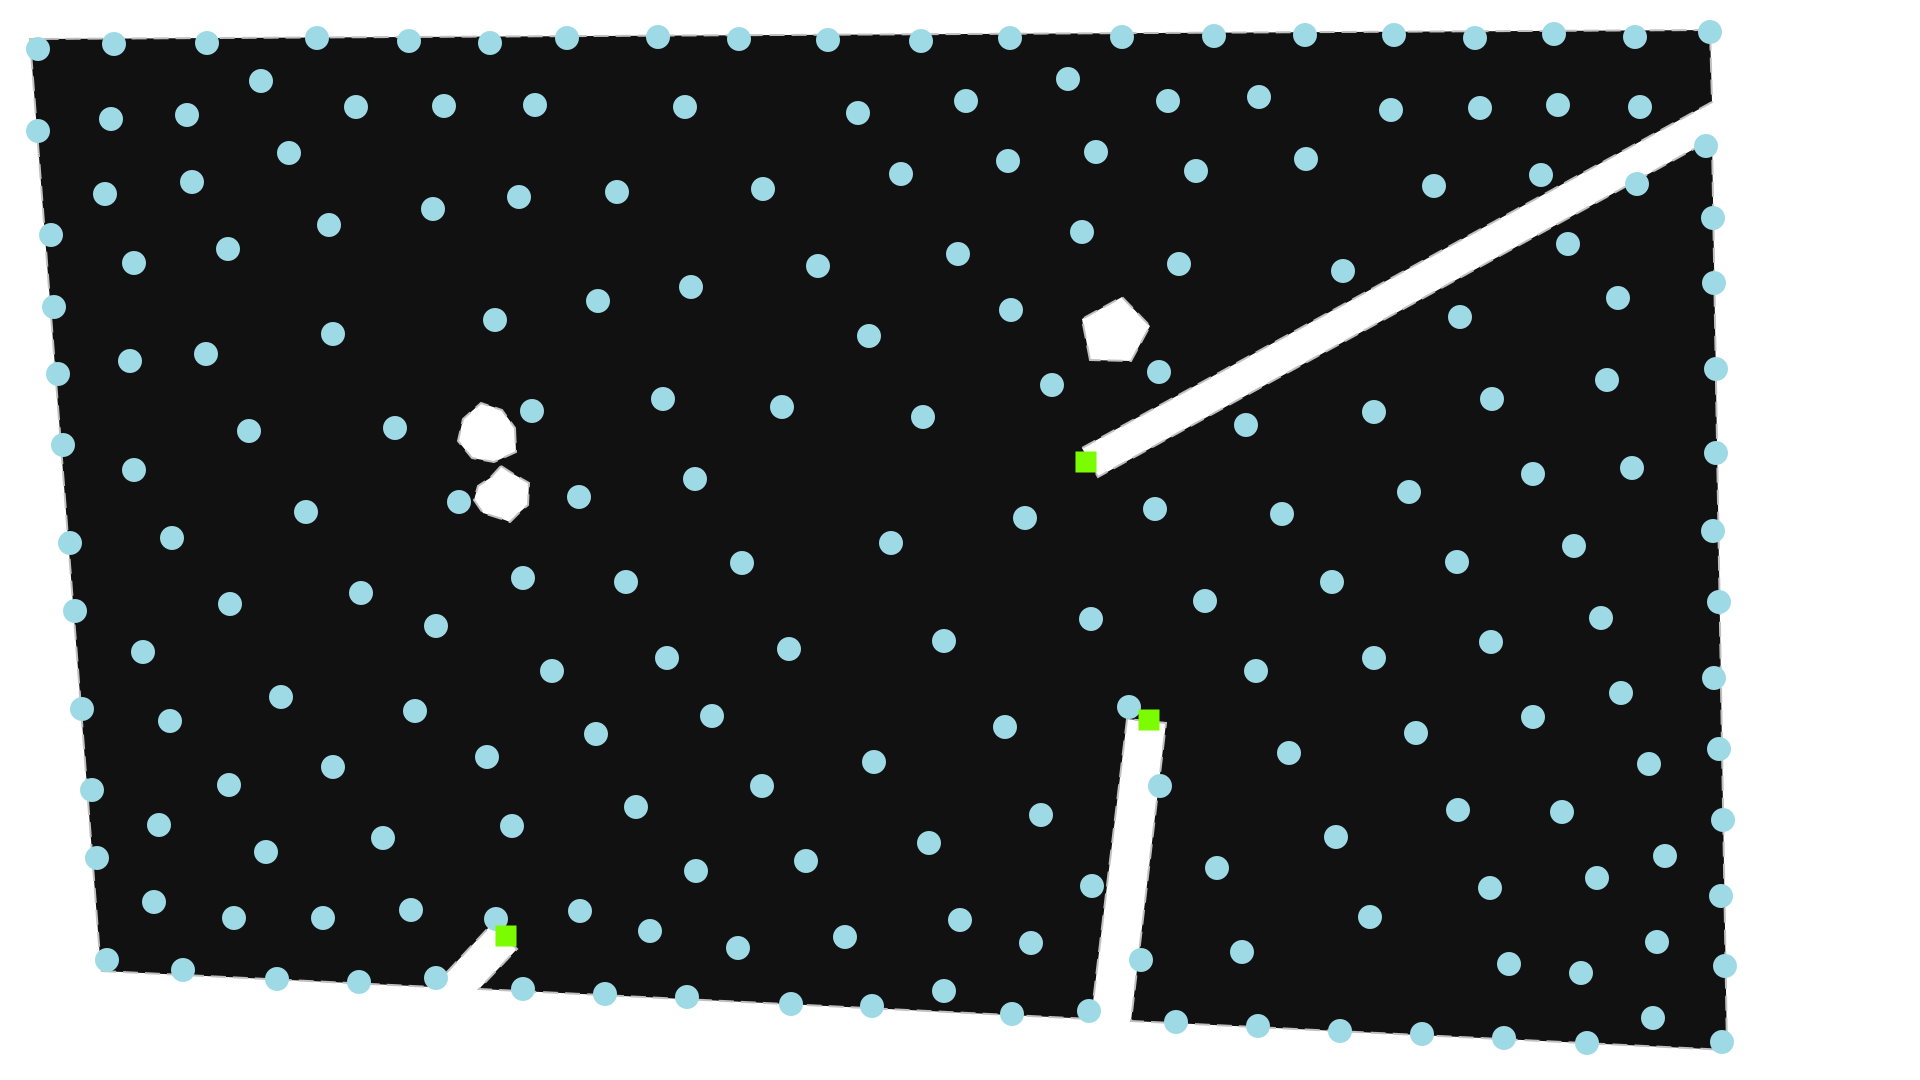

In [28]:
svgplot(L210)

In [29]:
Sʹ = hgs_multiroot(A, capacity=7, time_limit=1)

In [30]:
Sʹ.graph['solution_time']

(0.29, 0.43, 0.62)

In [31]:
Gʹ = G_from_S(Sʹ, A)

In [32]:
Hʹ = PathFinder(Gʹ, planar=P, A=A, branching=False).create_detours()

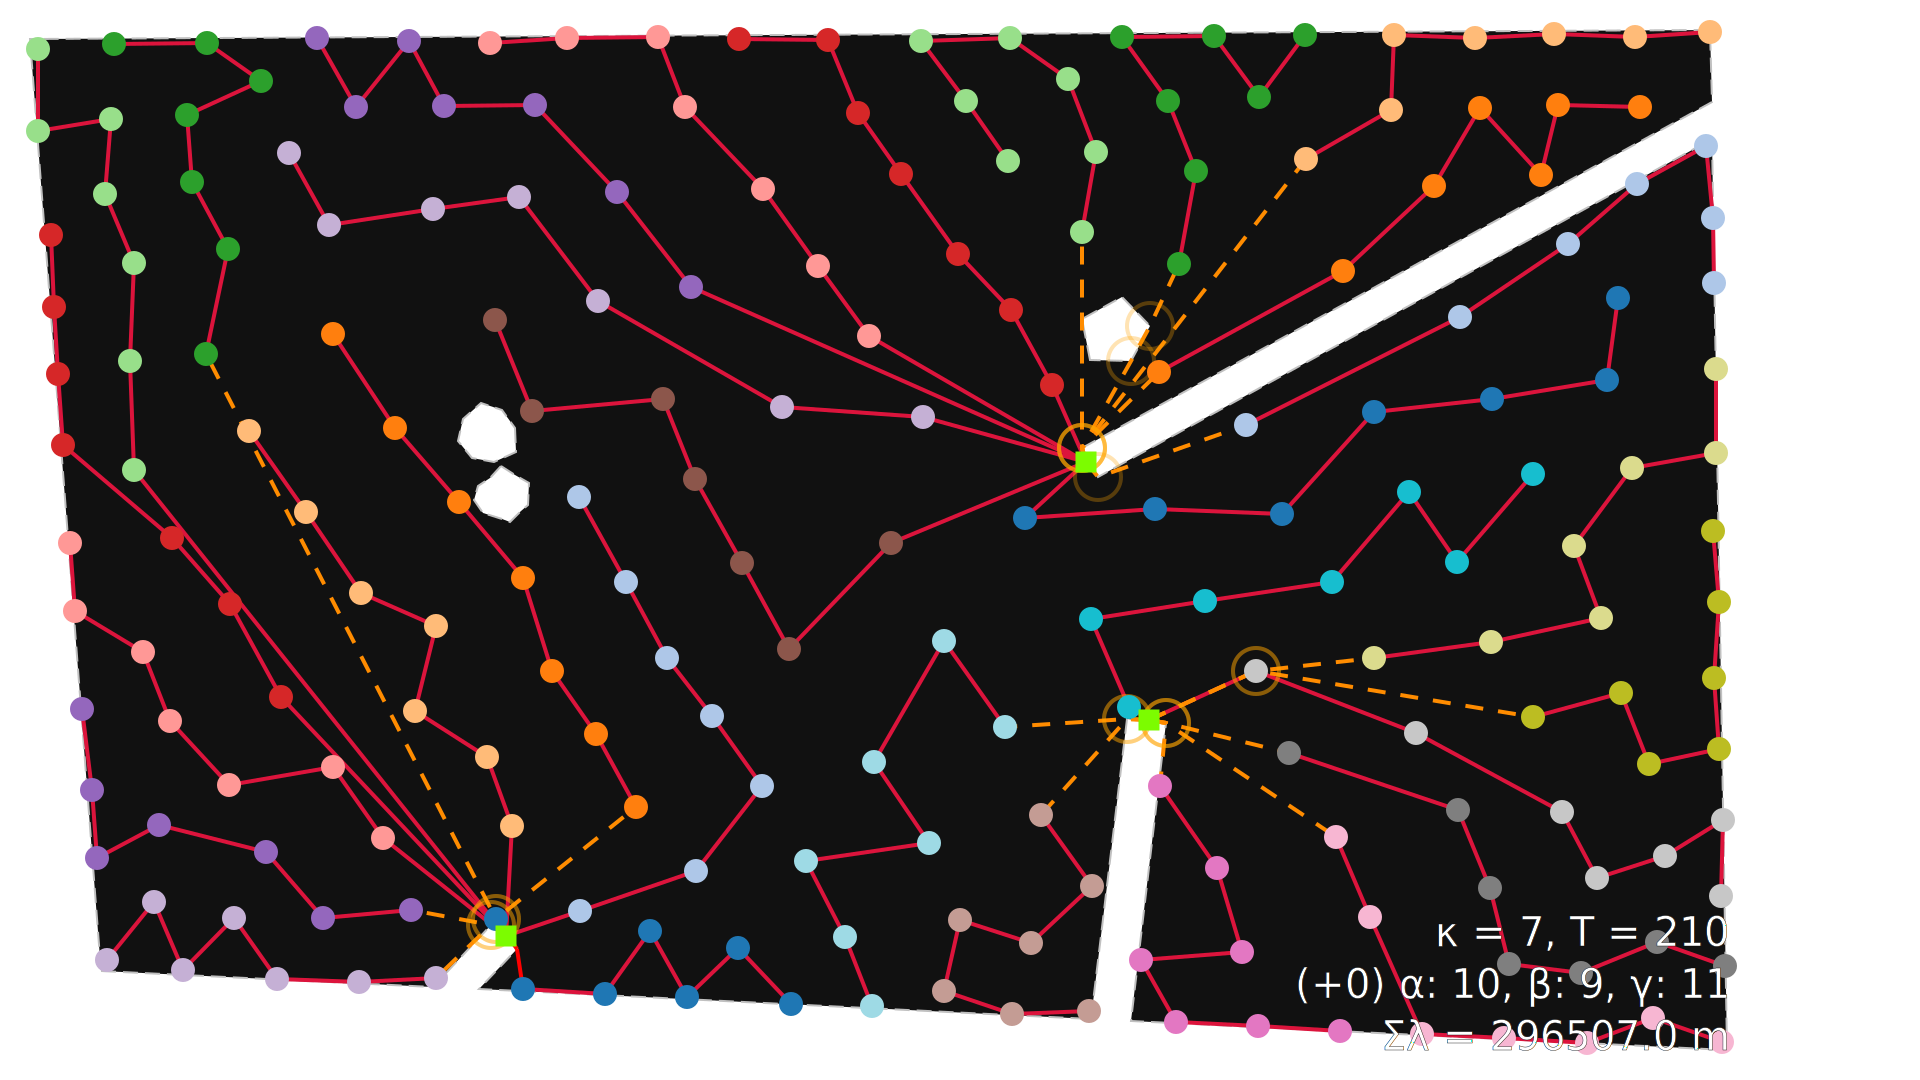

In [33]:
svgplot(Hʹ)

In [34]:
1- Hʹ.size(weight='length')/G210_ref.size(weight='length')

0.016487985205086986

### Solve the balanced MILP model

#### 90 s Gurobi

In [35]:
capacity = 7
# build model and pre-load solution from Sʹ
model = omo.make_min_length_model_balanced(
    A, capacity,
    num_gates=math.ceil(A.graph['T']/capacity),
    gateXings_constraint=False,
    branching=False
)
omo.warmup_model_balanced(model, Sʹ)

In [36]:
gurober.options.mipgap = 0.005  # 0.5 %
gurober.options.timelimit = 90  # [s]
gurober.options.mipfocus = 1  # focus on producing solutions
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, k={model.k.value}}}\n')
status = gurober.solve(model, warmstart=True, tee=True)

Solving "None": {R=3, T=210, k=7}

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 90
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  90
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 6839 rows, 5276 columns and 33164 nonzeros
Model fingerprint: 0x63a48781
Variable types: 0 continuous, 5276 integer (3268 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [3e+02, 2e+04]
  Bounds range     [1e+00, 6e+00]
  RHS range        [1e+00, 2e+02]

Loaded user MIP start with objective 296406

Presolve removed 1103 rows and 1050 columns
Presolve time

In [37]:
H210 = omo.gurobi_investigate_pool_balanced(P, A, model, gurober, status)

Solution pool has 5 solutions.
Incumbent has (detoured) length: 296826.130
Incumbent has (detoured) length: 295742.491
Pool investigation over - next best undetoured length: 296168.041


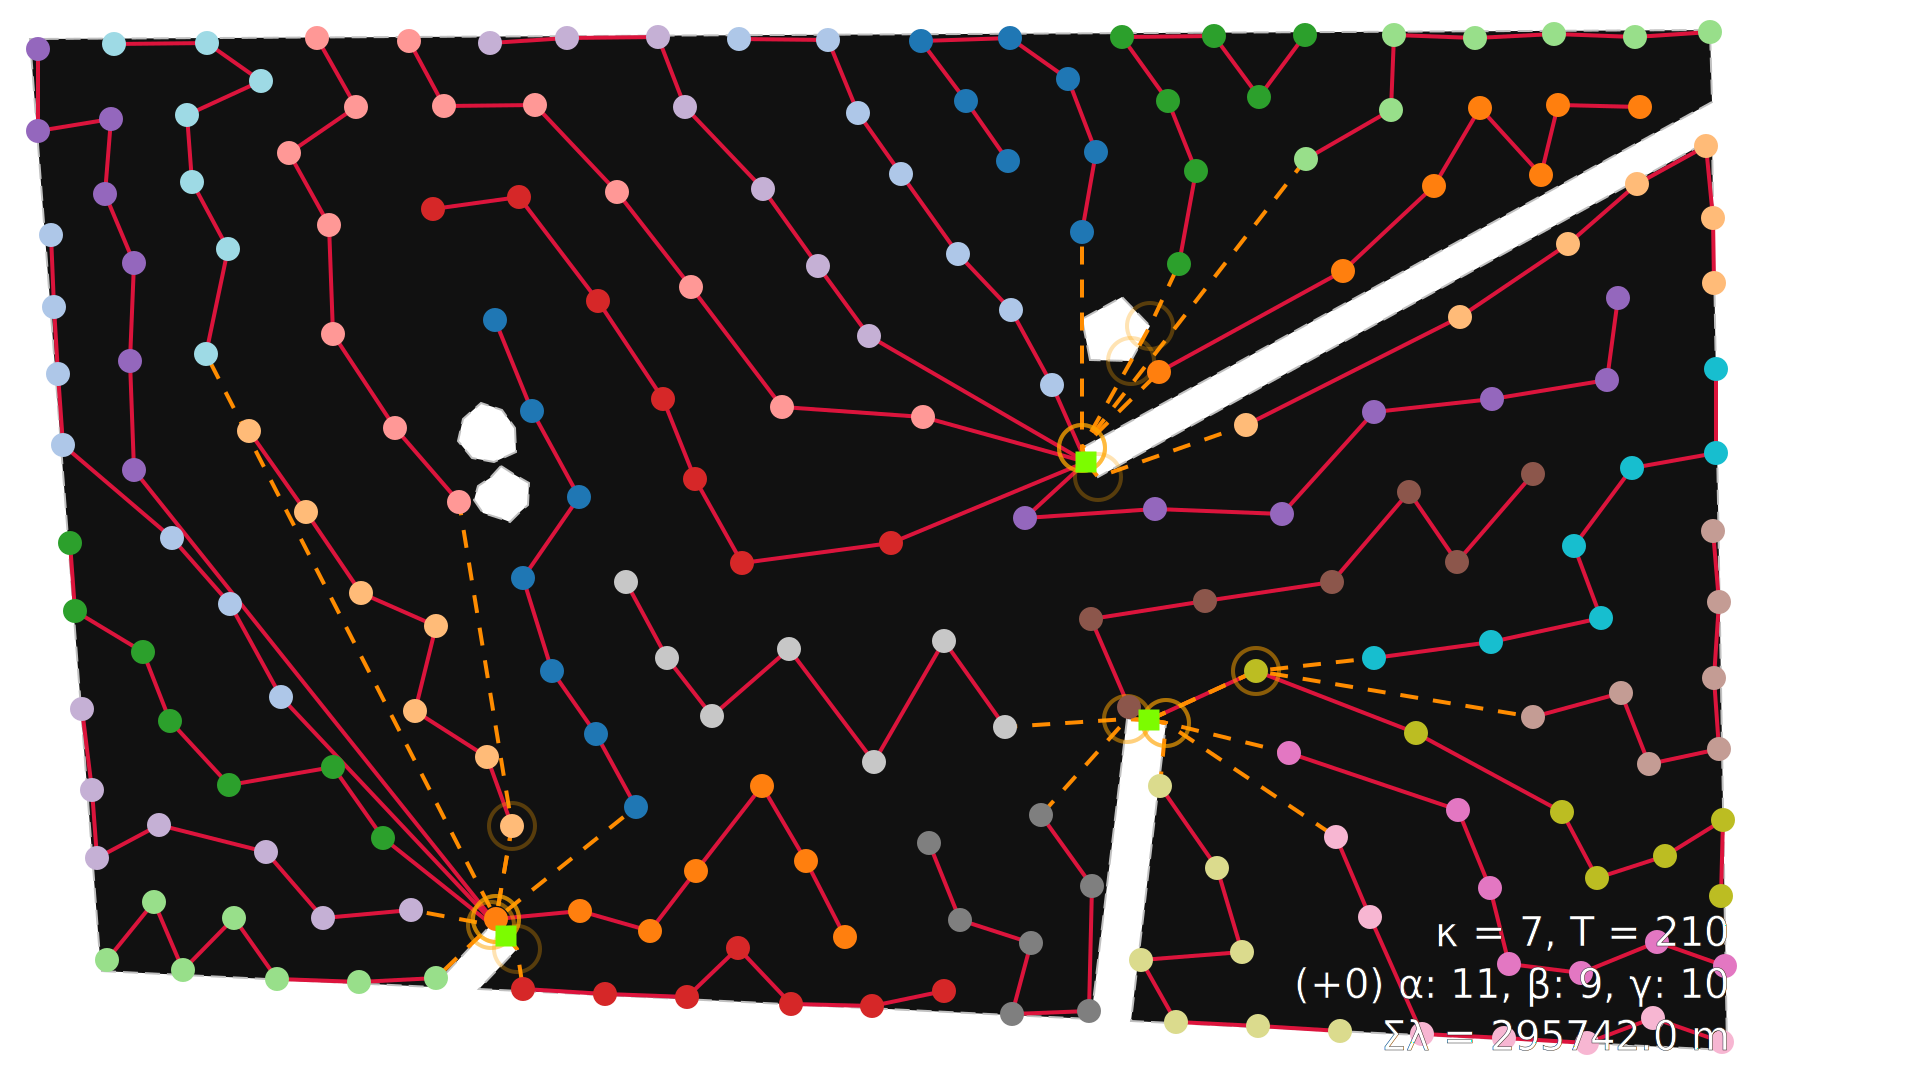

In [38]:
svgplot(H210)

In [39]:
with open('cazzaro_2022G_210_κ_7_radial_balanced_ours_295742.dill', 'wb') as outfile:
    dill.dump(H210, outfile)

In [40]:
1 - H210.size(weight='length')/G210_ref.size(weight='length')

0.019023001338116297